In [1]:
from brian2 import *
import math
# brian2tools import *
import numpy as np
%matplotlib inline

In [2]:
# SIMULATION PARAMETERS

prefs.codegen.target = 'numpy'

# the numerical resolution method that shall be used by Brian
diff_method = "euler"
time_step = 0.01 * ms
defaultclock.dt = time_step 

In [3]:
################################## NEURONS AND SYNAPSES PARAMETERS ################################## 
######### (A) Neuronal parameters, used in (1) and (4) ########

# time constants
tau_m = 1.0 * ms
tau_m_inh = 0.5 * ms

# membrane potential after reset
v_rest = 0.0

# spiking threshold
theta_u = 0.5
theta_inh = 0.01

########## (B) Synaptic parameters, used in (2) and (3) for different synapse types ######### 

# temporal layer to som layer (u to v)
tau_r_afferent = 0.2 * ms
tau_f_afferent = 1.0 * ms

# temporal layer (u to inh exc, u to inh inh, inh to u)
tau_r_exc = 0.4 * ms
tau_f_exc = 2.0 * ms
tau_r_inh = 0.2 * ms
tau_f_inh = 1.0 * ms
tau_r_inh2u = 1.0 * ms
tau_f_inh2u = 5.0 * ms

########## (C) Maximum magnitudes of synaptic connection strength ##########
w_syn_u2inh_exc_max = 1.0
w_syn_u2inh_inh_max = 1.0
w_syn_inh2u_max = 100.0
w_syn_v2v_max = 2.2
w_syn_u2v_max = 1.0
a = 3.0
b = 3.0
r = 3.0

In [4]:
def toroidalDistance2(x1,x2):
    dx = np.abs(x1 - x2)
    tor_dist = np.where(dx < 0, dx, 1.0 - dx)
    return tor_dist

In [5]:
class ReceptiveField:
    # Parameter used in standard deviation definition
    gamma = 1.5
    
    # bank_size : pour un vecteur de 3 valeurs, on aura 10 neurones pour chaque valeur
    def __init__(self,bank_size = 10, I_min = 0.05, I_max = 0.95):
        # number of units used to encode a real value  

        
        # field_mu corresponds to the mean of the gaussian and shall be a numpy array 
        #self.field_mu = array([0.05 , 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])
        
        self.field_mu = []
        for i in range(bank_size): 
            mu_i = I_min + ((2*i - 2 /2)*(I_max - I_min)/(2*(bank_size - 1)))
            self.field_mu.append(mu_i)
        
        # field_sigma corresponds to the standard deviation of the gaussian and shall be a float
        self.field_sigma = (I_max - I_min)/ self.gamma

    def float_to_potential(self, input_vector):
        try:
            input_vector = input_vector.reshape((input_vector.shape[0], 1))
            
        except Exception as exc:
            print("Exception: {0}\nObject shape: {1}".format(repr(exc), input_vector.shape))
            exit(1)
            
        #result = e**(-((toroidalDistance2(input_vector, self.field_mu)**2) /(2*self.field_sigma))) 
        result = e**(-((input_vector - self.field_mu)**2) /(2*self.field_sigma)**2)
        return result

In [6]:
#1 testing float_to_potential function
receptiveF = ReceptiveField()
input_dimension = 2
x = np.random.uniform(0,1,input_dimension)
input_potential = receptiveF.float_to_potential(x)

In [7]:
start_scope()
u_layer_neuron_equ = '''
I_ext : 1
dv/dt = (I_ext - v)/tau_m  : 1
'''

u_layer_neuron_equ2 = '''
I_ext : 1
# inhibitory synapses to u layer : alpha functions
ds_inh2u/dt = (-s_inh2u)/tau_r_inh2u:1
dI_inh2u/dt = (s_inh2u-I_inh2u)/tau_f_inh2u :1

# membrane potential of u layer 
dv/dt = (-v +I_ext - I_inh2u) / tau_m:1
'''


In [8]:
u_layer = NeuronGroup(2 * 10, u_layer_neuron_equ, threshold='v > 0.5', reset= "v=0", method = diff_method)
# U doit avoir un vecteru d'une seule dimension en entrée
u_layer.I_ext = input_potential.flatten()

u_layer2 = NeuronGroup(2 * 10, u_layer_neuron_equ2, threshold='v > 0.5', reset= "v=0", method = diff_method)
# U doit avoir un vecteru d'une seule dimension en entrée
u_layer2.I_ext = input_potential.flatten()



In [9]:
spikemon_u_layer = SpikeMonitor(u_layer, variables='v')
spikemon_u_layer2 = SpikeMonitor(u_layer2, variables='v')

state_u_layer2 = StateMonitor(u_layer2, variables='v', record = 0)


In [10]:
#5
inhibition_neuron_equ = '''

# inhibitory synapses from u to Inh neuron : alpha functions
ds_u2inh_e/dt = (-s_u2inh_e)/tau_r_exc :1
dI_u2inh_e/dt = (s_u2inh_e-I_u2inh_e)/tau_f_exc :1
ds_u2inh_i/dt = (-s_u2inh_i)/tau_r_inh :1
dI_u2inh_i/dt = (s_u2inh_i-I_u2inh_i)/tau_f_inh :1


# membrane potential of u layer 
dv/dt = (-v + I_u2inh_e - I_u2inh_i) / tau_m_inh :1
'''



In [11]:
#6

inhibition_neuron = NeuronGroup(1, inhibition_neuron_equ, threshold='v> 0.01', reset= "v=0", method = diff_method)
spikemon_inh_layer = SpikeMonitor(inhibition_neuron, variables='v')
statemon_inh_layer = StateMonitor(inhibition_neuron, 'v', record = 0)

#7 synapse excitation

model_synapse_u2inh_excitation = '''
w_syn : 1
'''

on_pre_synapse_u2inh_excitation = '''
s_u2inh_e += w_syn
'''
#8
u2inh_excitation = Synapses (u_layer2, inhibition_neuron,model_synapse_u2inh_excitation, on_pre_synapse_u2inh_excitation )
u2inh_excitation.connect()

weights_u2inh = [0] * 20
for i in range(19)  :
    weights_u2inh[i] = w_syn_u2inh_exc_max / 5
    
u2inh_excitation.w_syn = weights_u2inh

In [12]:
#10 synapse inhibition

model_synapse_u2inh_inhibition = '''
w_syn : 1
'''

on_pre_synapse_u2inh_inhibition = '''
s_u2inh_i += w_syn
'''

u2inh_inhibition = Synapses (u_layer2, inhibition_neuron,model_synapse_u2inh_inhibition, on_pre_synapse_u2inh_inhibition )
u2inh_inhibition.connect()

weights_u2inh_inh = [0] * 20
for q in range(19)  :
    weights_u2inh_inh[q] = w_syn_u2inh_inh_max / 5
    
u2inh_inhibition.w_syn = weights_u2inh_inh

u2inh_inhibition.active

True

In [13]:
#10 synapse inhibition inh to u

model_synapse_inh2u_inhibition = '''
w_syn : 1
'''

on_pre_synapse_inh2u_inhibition = '''
s_inh2u += w_syn
'''

inh2u_inhibition = Synapses (inhibition_neuron, u_layer2, model_synapse_inh2u_inhibition, on_pre_synapse_inh2u_inhibition )
inh2u_inhibition.connect()

weights_inh2u = [0] * 20
for k in range(19)  :
    weights_inh2u[k] = w_syn_inh2u_max / 5
    
inh2u_inhibition.w_syn = weights_inh2u

inh2u_inhibition.active

True

In [14]:
#partie 2
v_layer_neuron_equ = '''
u2v : 1

# inhibitory synapses to u layer : alpha functions
ds_v2v/dt = (-s_v2v)/tau_r_afferent:1
dI_v2v/dt = (s_v2v-u2v)/tau_f_afferent :1

dv/dt = (u2v - v + I_v2v ) /tau_m :1

'''

In [15]:
v_layer = NeuronGroup(2 * 10, v_layer_neuron_equ, threshold='v > 1', reset= "v=0", method = diff_method)

In [16]:
# synapses inhibition v to v

model_synapse_v2v = '''
w_syn : 1
'''

on_pre_synapse_v2v = '''
s_v2v += w_syn
'''

v2v = Synapses (v_layer, v_layer, model_synapse_v2v, on_pre_synapse_v2v )
v2v.connect(condition='i!=j')

weights_v2v = [0] * 380
for z in range(19)  :
    weights_v2v[z] = w_syn_v2v_max / 5
    
v2v.w_syn = weights_v2v

v2v.active

WARNING    "i" is an internal variable of group "synapses_3", but also exists in the run namespace with the value 18. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


True

In [17]:
def syn_weight():
    result = []
    for i in range(20):
        for j in range(20): 
            if (i != j):
                result.append ((1 + a )*e**(-(toroidalDistance2(i,j)**2)/(2* r**2)) - a * e**(-(toroidalDistance2(i,j)**2)/(2* (b*r)**2)) ) 
    return result

In [18]:
v2v.w_syn=syn_weight()

In [19]:
#synapses u to v
model_synapse_u2v = '''
w_syn : 1
'''

on_pre_synapse_u2v = '''
u2v += w_syn
'''

u2v = Synapses (u_layer2, v_layer,model_synapse_u2v, on_pre_synapse_u2v )
u2v.connect()


    
u2v.w_syn =  np.random.uniform(0,w_syn_u2v_max, 400)
u2v.active

True

In [20]:
spikemon_v_layer = SpikeMonitor(v_layer, variables='v')


M = StateMonitor(v_layer, 'v', record=True)

In [21]:
run(10*ms)
print(u2inh_excitation.active, u2inh_inhibition.active ,inh2u_inhibition.active, u2v.active, v2v.active )

True True True True True


True

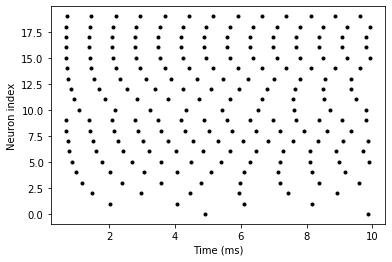

In [22]:
#sans inh
plot(spikemon_u_layer.t/ms, spikemon_u_layer.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
spikemon_u_layer.active

True

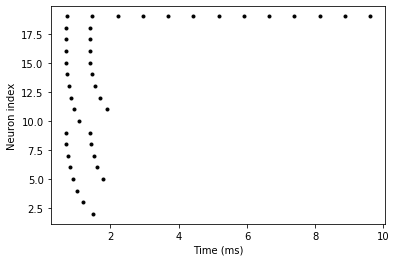

In [23]:
plot(spikemon_u_layer2.t/ms, spikemon_u_layer2.i, '.k')

xlabel('Time (ms)')
ylabel('Neuron index')



spikemon_u_layer2.active

Text(0.5, 1.0, 'Potentiel membranaire')

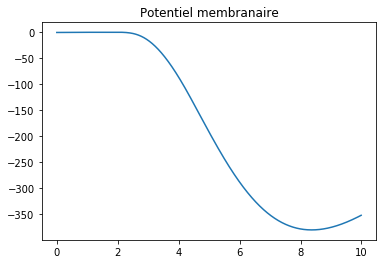

In [24]:

plot(state_u_layer2.t/ms,state_u_layer2.v[0] )
title('Potentiel membranaire')



Text(0, 0.5, 'Mv')

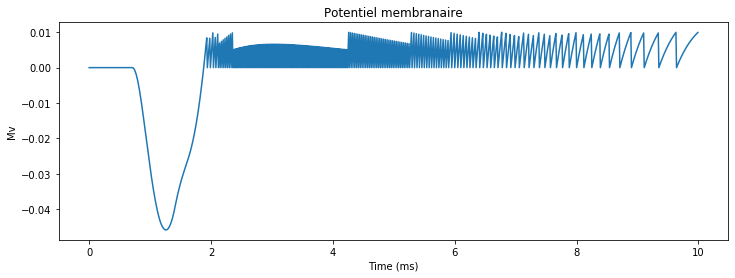

In [25]:

figure(figsize=(12,4))
plot(statemon_inh_layer.t/ms,statemon_inh_layer.v[0] )
title('Potentiel membranaire')
xlabel('Time (ms)')
ylabel('Mv')


Text(0, 0.5, 'Mv')

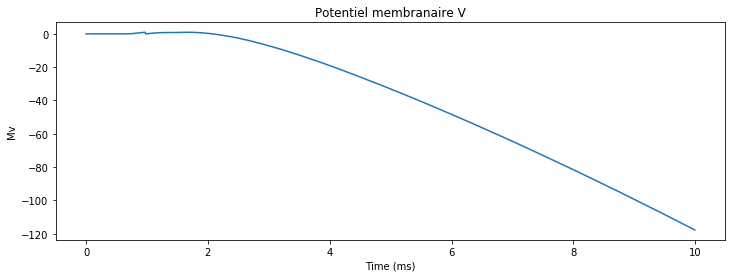

In [26]:
figure(figsize=(12,4))
plot(M.t/ms,M.v[0] )
title('Potentiel membranaire V')
xlabel('Time (ms)')
ylabel('Mv')


ValueError: x and y must have same first dimension, but have shapes (41,) and (1000,)

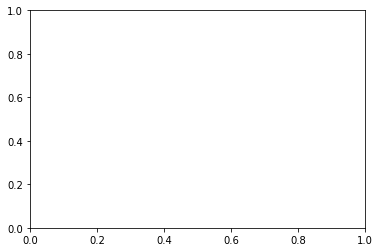

In [27]:
plot(spikemon_v_layer.t/ms, M.v[0], label='Neurone 0')

In [ ]:
print(v_layer.v[0], inhibition_neuron.v[0]) 